In [28]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [26]:
batch_size,num_steps = 32,35

train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [24]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [31]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = self.get_params(vocab_size, num_hiddens, device)
        self.device=device
        
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def forward_fn(self,inputs,state,params):
        # inputs的形状：(时间步数量，批量大小，词表大小)
        W_xh, W_hh, b_h, W_hq, b_q = params
        H, = state
        outputs = []
        # X的形状：(批量大小，词表大小)
        for X in inputs:
            H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
            Y = torch.mm(H, W_hq) + b_q
            outputs.append(Y)
        return torch.cat(outputs,dim=0),(H,)
    
    def get_params(self,vocab_size, num_hiddens, device):
        num_inputs = num_outputs = vocab_size
        def normal(shape):
            return torch.randn(size=shape, device=device) * 0.01
        # 隐藏层参数
        W_xh = normal((num_inputs, num_hiddens))
        W_hh = normal((num_hiddens, num_hiddens))
        b_h = torch.zeros(num_hiddens, device=device)
        # 输出层参数
        W_hq = normal((num_hiddens, num_outputs))
        b_q = torch.zeros(num_outputs, device=device)
        # 附加梯度
        params = [W_xh, W_hh, b_h, W_hq, b_q]
        for param in params:
            param.requires_grad_(True)
        return params
    def init_state(self,batch_size,num_hiddens=512,device='cuda:0'):
        return (torch.zeros((batch_size , num_hiddens), device=device), )

In [34]:
num_hiddens = 512
net = RNNModelScratch(len(vocab),num_hiddens,'cuda:0')
state=net.init_state(X.shape[0],num_hiddens)
Y, new_state = net(X.to('cuda:0'), state)

In [35]:
def predict_RNN(prefix,num_preds,net,vocab,device):
    state=net.init_state(batch_size=1,device=device)
    outputs=[vocab[prefix[0]]]
    get_input=lambda :torch.tensor([outputs[-1]],device=device).reshape((1,1))
    for y in prefix[1:]:
        _,state =net(get_input(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [36]:
predict_RNN('time trin',10,net,vocab,'cuda:0')

'time trinhvrimx<unk>plj'

In [47]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
def train_one_epoch(net,train_iter,loss,optimer,device,use_random_iter):
    state, timer = None, d2l.Timer()
    metric =d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.init_state(batch_size=X.shape[0])
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X,y=X.to(device),y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(optimer, torch.optim.Optimizer):
            optimer.zero_grad()
            l.sum().backward()
            grad_clipping(net,1)
            optimer.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            optimer(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
            

In [49]:
def train_rnn(net,train_iter,vocab,lr,num_epochs,device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[5, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_RNN(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_one_epoch(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
            print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
            print(predict('time traveller'))
            print(predict('traveller'))

困惑度 8.6, 184991.0 词元/秒 cuda:0
time travellere the sad the sad the sad the sad the sad the sad 
travellere the sad the sad the sad the sad the sad the sad 


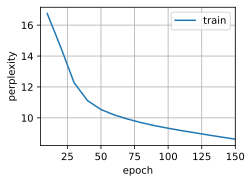

In [50]:
train_rnn(net,train_iter,vocab,lr=0.02,num_epochs=150,device='cuda:0')